In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 25.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

def eda(Xt, Yt, Xtest, Ytest):
    print(Xt.shape, Yt.shape)
    print(Xtest.shape, Ytest.shape)

    print(Xt.dtype, Yt.dtype)
    print(Xtest.dtype, Ytest.dtype)

    plt.figure(figsize=(7,2))
    plt.subplot(121)
    plt.hist(Yt)
    plt.subplot(122)
    plt.hist(Ytest)
    plt.show()

    print('clase, Ytest/Yt, Nt, Ntest')
    for i in range(5):
        strain, stest = (Yt == i).sum(), (Ytest == i).sum()
        p = round(stest/strain, 4)
        print(i, p, strain, stest)

    print()
    print('statistics')
    print(Xt.mean(), Xt.std(), Xt.min(), Xt.max())
    print(Xtest.mean(), Xtest.std(), Xtest.min(), Xtest.max())

import sklearn as sk
from mlxtend.evaluate import accuracy_score

def evaluation(classifier, Ytest, Ypred, tree=False):
    std_acc = accuracy_score(Ytest, Ypred)
    avg_acc = accuracy_score(Ytest, Ypred, method='average')
    bin_acc0 = accuracy_score(Ytest, Ypred, method='binary', pos_label=0)
    bin_acc1 = accuracy_score(Ytest, Ypred, method='binary', pos_label=1)
    bin_acc2 = accuracy_score(Ytest, Ypred, method='binary', pos_label=2)
    bin_acc3 = accuracy_score(Ytest, Ypred, method='binary', pos_label=3)
    bin_acc4 = accuracy_score(Ytest, Ypred, method='binary', pos_label=4)
    class_precision = sk.metrics.precision_score (Ytest, Ypred, average = None)
    recall = sk.metrics.recall_score(Ytest, Ypred, average= None)
    f1macro = sk.metrics.f1_score(Ytest, Ypred, average="macro")

    print(f'f1-macro:                   {f1macro:.4f}')
    print(f'Standard accuracy:          {std_acc:.4f}')
    print(f'Average per-class accuracy: {avg_acc:.4f}')
    print ()
    print(f'Normal accuracy: {bin_acc0:.4f}')
    print(f'DoS accuracy:    {bin_acc1:.4f}')
    print(f'Probe accuracy:  {bin_acc2:.4f}')
    print(f'R2L accuracy:    {bin_acc3:.4f}')
    print(f'U2R accuracy:    {bin_acc4:.4f}')
    print()
    print(f"Normal Precision: {class_precision[0]:.4f}")
    print(f"DoS Precision:    {class_precision[1]:.4f}")
    print(f"Probe Precision:  {class_precision[2]:.4f}")
    print(f"R2L Precision:    {class_precision[3]:.4f}")
    print(f"U2R Precision:    {class_precision[4]:.4f}")
    print()
    print(f"Normal Recall: {recall[0]:.4f}")
    print(f"DoS Recall:    {recall[1]:.4f}")
    print(f"Probe Recall:  {recall[2]:.4f}")
    print(f"R2L Recall:    {recall[3]:.4f}")
    print(f"U2R Recall:    {recall[4]:.4f}")

    confusion_matrix = sk.metrics.confusion_matrix(Ytest, Ypred)
    cm_display = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.show()

    if tree:
        sk.tree.plot_tree(classifier, fontsize=1)
    return None

### Original split

(125973, 122) (125973,)
(22544, 122) (22544,)
float64 float64
float64 float64


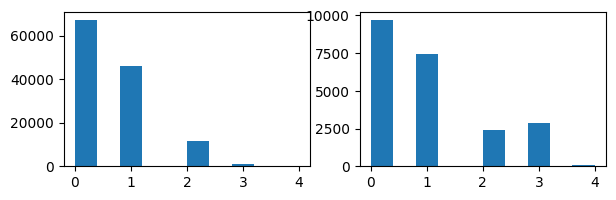

clase, Ytest/Yt, Nt, Ntest
0 0.1442 67343 9711
1 0.1624 45927 7460
2 0.2077 11656 2421
3 2.8995 995 2885
4 1.2885 52 67

statistics
0.06601799149797134 0.24008983284759014 0.0 1.0000000000000002
0.06743799560348274 0.24247147856107026 0.0 1.0


In [ ]:
from joblib import load
import numpy as np
from sklearn.utils import shuffle

dsdir = 'datasets/'
Dnormal_train = load(dsdir + "normal_train_preprocess.joblib")
Dattacks_train = load(dsdir + "Attacks_train_preprocess.joblib")
Dnormal_test = load(dsdir + "normal_test_preprocess.joblib")
Dattacks_test = load(dsdir + "Attacks_test_preprocess.joblib")
Dtrain = np.concatenate([Dnormal_train,Dattacks_train])
Dtest = np.concatenate([Dnormal_test,Dattacks_test])

Xt, Yt = shuffle(Dtrain[:, 0:122], Dtrain[:,122], random_state=0)
Xtest, Ytest = Dtest[:, 0:122], Dtest[:,122]
datasets = {"original": (Xt, Yt, Xtest, Ytest)}
eda(Xt, Yt, Xtest, Ytest)

In [ ]:
from tqdm import tqdm
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from tabpfn import TabPFNClassifier
#from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import torch

class CatBoostClassifierv2(CatBoostClassifier):
    def predict(self, x):
        y = super().predict(x)
        return np.squeeze(y)

clfs = {'dtree': lambda seed: DecisionTreeClassifier(random_state=seed),
        'svm': lambda seed: svm.SVC(random_state=seed),
        'xgboost': lambda seed: XGBClassifier(seed=seed),
        'randomforest': lambda seed: RandomForestClassifier(random_state=seed),
        'catboost': lambda seed: CatBoostClassifierv2(random_state=seed, verbose=0),
        #'mlp': lambda seed: MLPClassifier(random_state=seed, max_iter=300),
        'tabpfn': lambda seed: TabPFNClassifier(random_state=seed),  # Debo limitar el nuero de instacias < 10000
        'autotabpfn': lambda seed: AutoTabPFNClassifier(random_state=seed, max_time=30, device="cuda"),  # Debo limitar el nuero de instacias < 10000
}

In [ ]:
def addOnlyErrors(Xtrain, Ytrain, batch_size, n_epochs, clf, Xtest, Ytest):
    """ Selection strategy based on adding only errors """
    # Initialization
    Xt_shuffled, Yt_shuffled = shuffle(Xtrain, Ytrain)
    _, unique_indices = np.unique(Yt_shuffled, return_index=True)
    x, y = Xt_shuffled[unique_indices], Yt_shuffled[unique_indices]
    clf.fit(x, y)
    n_samples = [len(x)]
    f1_scores = [f1_score(Ytest, clf.predict(Xtest), average='macro')]
    for epoch in (pbar := tqdm(range(n_epochs))):
        #pbar.set_description(f"Processing epoch: {epoch}")
        torch.cuda.empty_cache()
        Xt_shuffled, Yt_shuffled = shuffle(Xtrain, Ytrain)
        for i in range(0, len(Xt_shuffled), batch_size):
            # Add errors of the next batch
            dx, dy = Xt_shuffled[i:i+batch_size], Yt_shuffled[i:i+batch_size]
            dypred = clf.predict(dx)
            x = np.concatenate([x, dx[dypred != dy, :]])
            y = np.concatenate([y, dy[dypred != dy]])
            clf.fit(x, y)
            n_samples += [len(x)]
            f1_scores.append(f1_score(Ytest, clf.predict(Xtest), average='macro'))
    return x, y, clf, n_samples, f1_scores

In [ ]:
import pickle

bs = 1000
Nseeds = 25
n_epochs = 5
clflabels = ["tabpfn"]

for dsname in ["original"]:
    print(f"Running for {dsname} dataset")
    Xt, Yt, Xtest, Ytest = datasets[dsname]
    outdir = f"outputs_study_aoe/normal_attacks_{dsname}/"
    Path(outdir).mkdir(parents=True, exist_ok=True)
    for clflabel in clflabels:
        NS, F1, datasets = [], [], []
        for _ in tqdm(range(Nseeds)):
            xr, yr, clf, n_samples, f1_scores = addOnlyErrors(Xt, Yt, bs, n_epochs, clfs[clflabel](seed=None), Xtest, Ytest)
            del clf
            # save the model
            NS.append(np.array(n_samples))
            F1.append(np.array(f1_scores))
            datasets.append((xr, yr))
        # save the results
        np.savez_compressed(outdir + f"{clflabel}_nsamples_f1scores.npz", NS=np.array(NS), F1=np.array(F1))
        with open(outdir + f"{clflabel}_datasets.pkl", "wb") as f:
            pickle.dump(datasets, f)
        print(f"Results for {clflabel} classifier has been saved")


Running for original dataset


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
import shutil

carpeta_origen = "/content/outputs_study_aoe/"
archivo_zip_salida = f"/content/outputs"
shutil.make_archive(archivo_zip_salida, 'zip', carpeta_origen)

print(f"Archivo ZIP creado: {archivo_zip_salida}.zip")
from google.colab import files
files.download(f"{archivo_zip_salida}.zip")

Archivo ZIP creado: /content/outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>